### Задача

Гуляя в саду, он не мог отличить яблоки от груш (которые были ему совершенно ненавистны), не попробовав их на вкус.

Сформировав путём горьких ошибок небольшой набор данных, Зюк достал какое-то странное устройство и начал программировать перцептрон.

Характеристики: симметричность и желтизна объекта.

### Загрузка данных

Первым делом мы решили подготовить всё, что нам может понадобится, и разобраться с набором данных:

In [2]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as p3
import numpy as np
import random
import time

from functools import partial
from ipywidgets import interact, RadioButtons, IntSlider, FloatSlider, Dropdown, BoundedFloatText
from numpy.linalg import norm

random.seed(42) # начальное состояние генератора случайных чисел, чтобы можно было воспроизводить результаты.

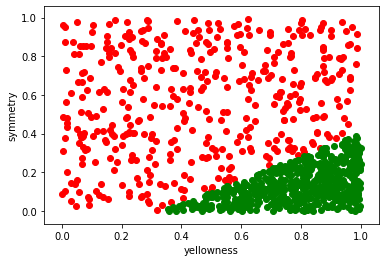

In [3]:
%matplotlib inline
data = np.loadtxt("data.csv", delimiter=",")
pears = data[:, 2] == 1
apples = np.logical_not(pears)
plt.scatter(data[apples][:, 0], data[apples][:, 1], color = "red")
plt.scatter(data[pears][:, 0], data[pears][:, 1], color = "green")
plt.xlabel("yellowness")
plt.ylabel("symmetry")
plt.show()

Данные -  матрица $1000 \times 3$, в каждой строке указаны желтизна и симметричность очередного фрукта (в первой и второй колонках) и его сортовая принадлежность (третья колонка, 0 - яблоки, 1 - груши).

Сперва нужно решить, какой вообще будет структура модуля, распознающего яблоки и груши. Мы призадумались, и он с ностальгической улыбкой показал нам одну из своих заготовок:

# Перцептрон

In [4]:
class Perceptron:

    def __init__(self, w, b):
        """
        Инициализируем наш объект - перцептрон.
        w - вектор весов размера (m, 1), где m - количество переменных
        b - число
        """
        
        self.w = w
        self.b = b

    def forward_pass(self, single_input):
        """
        Метод рассчитывает ответ перцептрона при предъявлении одного примера
        single_input - вектор примера размера (m, 1).
        Метод возвращает число (0 или 1) или boolean (True/False)
        """
        
        result = 0
        for i in range(0, len(self.w)):
            result += self.w[i] * single_input[i]
        result += self.b
        
        if result > 0:
            return 1
        else:
            return 0

    def vectorized_forward_pass(self, input_matrix):
        """
        Метод рассчитывает ответ перцептрона при предъявлении набора примеров
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных
        Возвращает вертикальный вектор размера (n, 1) с ответами перцептрона
        (элементы вектора - boolean или целые числа (0 или 1))
        """
        
        # your code goes here
        return input_matrix.dot(self.w) + self.b > 0
    
    def train_on_single_example(self, example, y):
        """
        принимает вектор активации входов example формы (m, 1) 
        и правильный ответ для него (число 0 или 1 или boolean),
        обновляет значения весов перцептрона в соответствии с этим примером
        и возвращает размер ошибки, которая случилась на этом примере до изменения весов (0 или 1)
        (на её основании мы потом построим интересный график)
        """
        
        '''Pseudocode
        # example=один набор входных активаций размерности(m,1)
        # y = правильный ответ (число 0 или 1)
        predict = float(np.dot(self.w.T, example)+self.b)>0
        error = y-predict
        self.w = self.w + error*example
        #b = b + (y - \hat{y})
        #Если хотите понять, почему, вспомните, что b — такой же вес (w0), только соответств. ему х всегда равен 1      
        #Поэтому мы всегда либо прибавляем, либо отнимаем единицу.
        self.b = self.b + error
        '''    
        
        predict=vectorized_forward_pass(example.T)#because "example" is (m, 1), we need (n,m)
        self.w=self.w + (y-predict)*example 
        self.b=self.b + (predict)           
        pass #because for b х is 1, so we are + or - 1

 $$ y^{predict}=\hat{y}$$
 $${\Delta w} = ({y-\hat{y}})*{x}$$
 
 $${w} = {w + \Delta w} = {w + ({y-\hat{y}})*{x}}$$

### Реализовать метод `vectorized_forward_pass`

Это метод, который считает значения активационной функции нейрона. 

На вход он принимает матрицу активаций размера $n \times m$ и вектор ответов длины $n$. Каждая строка - отдельный пример. В случае с яблоками и грушами матрица будет размера $n \times 2$, где $n$ - количество примеров, для которых мы хотим получить решения (но, конечно, когда мы будем проверять ваши решения, у данных может быть и другой размер!).  `vectorized_forward_pass` отдаёт столбец (формы $n\times 1$) значений активационной функции нейрона для всех переданных ему входных данных. Зюк предупредил, что если мы будем использовать **циклы** (`for`, `while`) или **операторы ветвления** (`if`) - **решение не пройдёт его внутреннюю проверку**.

### Тестирование

У нас назрел вопрос: а так ли нужна эта векторизация для классификации яблок?
-"Так давайте проверим!".


In [5]:
def create_perceptron(m):
    """Создаём перцептрон со случайными весами и m входами"""
    w = np.random.random((m, 1))
    return Perceptron(w, 1)

In [6]:
def test_v_f_p(n, m):
    """
    Расчитывает для перцептрона с m входами
    с помощью методов forward_pass и vectorized_forward_pass
    n ответов перцептрона на случайных данных.
    Возвращает время, затраченное vectorized_forward_pass и forward_pass
    на эти расчёты.
    """
    
    p = create_perceptron(m)
    input_m = np.random.random_sample((n, m))
    
    start = time.clock()
    vec = p.vectorized_forward_pass(input_m)
    end = time.clock()
    vector_time = end - start
    
    start = time.clock()
    for i in range(0, n):
        p.forward_pass(input_m[i]) 
    end = time.clock()
    plain_time = end - start

    return [vector_time, plain_time]

In [7]:
def mean_execution_time(n, m, trials=100):
    """среднее время выполнения forward_pass и vectorized_forward_pass за trials испытаний"""
    
    return np.array([test_v_f_p(m, n) for _ in range(trials)]).mean(axis=0)

def plot_mean_execution_time(n, m):
    """рисует графики среднего времени выполнения forward_pass и vectorized_forward_pass"""
    
    mean_vectorized, mean_plain = mean_execution_time(int(n), int(m))
    p1 = plt.bar([0], mean_vectorized,  color='g')
    p2 = plt.bar([1], mean_plain, color='r')

    plt.ylabel("Time spent")
    plt.yticks(np.arange(0, mean_plain))

    plt.xticks(range(0,1))
    plt.legend(("vectorized","non - vectorized"))

    plt.show()

interact(plot_mean_execution_time, 
            n=RadioButtons(options=["1", "10", "100"]),
            m=RadioButtons(options=["1", "10", "100"], separator=" "));

interactive(children=(RadioButtons(description='n', options=('1', '10', '100'), value='1'), RadioButtons(descr…

Мы принялись увлечённо экспериментировать, чтобы лучше понять, какова разница во времени работы у векторизованного и не векторизованного вариантов при разных `n` и `m`. Нетрудно заметить, что чем больше у нас данных, тем более впечатляющей эта разница становилась. 

## Обучение перцептрона

Отлично, осталось научить наш перцептрон хорошо различать груши и яблоки! Напишем код, который, приняв на вход пример и правильный ответ, будет изменять веса в соответствии с правилом обучения перцептрона. 

Это метод `train_on_single_example`.

In [8]:
class Perceptron:

    def __init__(self, w, b):
        """
        Инициализируем наш объект - перцептрон.
        w - вектор весов размера (m, 1), где m - количество переменных
        b - число
        """
        
        self.w = w
        self.b = b

    def forward_pass(self, single_input):
        """
        Метод рассчитывает ответ перцептрона при предъявлении одного примера
        single_input - вектор примера размера (m, 1).
        Метод возвращает число (0 или 1) или boolean (True/False)
        """
        
        result = 0
        for i in range(0, len(self.w)):
            result += self.w[i] * single_input[i]
        result += self.b
        
        if result > 0:
            return 1
        else:
            return 0

    def vectorized_forward_pass(self, input_matrix):
        """
        Метод рассчитывает ответ перцептрона при предъявлении набора примеров
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных
        Возвращает вертикальный вектор размера (n, 1) с ответами перцептрона
        (элементы вектора - boolean или целые числа (0 или 1))
        """
        ## Этот метод необходимо реализовать #pass
        # your code goes here
        return input_matrix.dot(self.w) + self.b > 0
    
    def train_on_single_example(self, example, y):
        """
        принимает вектор активации входов example формы (m, 1) 
        и правильный ответ для него (число 0 или 1 или boolean),
        обновляет значения весов перцептрона в соответствии с этим примером
        и возвращает размер ошибки, которая случилась на этом примере до изменения весов (0 или 1)
        (на её основании мы потом построим интересный график)
        """
        
        # your code goes here
        predict=vectorized_forward_pass(example.T)#because "example" is (m, 1), we need (n,m)
        self.w=self.w + (y-predict)*example 
        self.b=self.b + (predict)           
        pass #because for b х is 1, so we are + or - 1
    
    def train_until_convergence(self, input_matrix, y, max_steps=1e8):
        """
        input_matrix - матрица входов размера (n, m),
        y - вектор правильных ответов размера (n, 1) (y[i] - правильный ответ на пример input_matrix[i]),
        max_steps - максимальное количество шагов.
        Применяем train_on_single_example, пока не перестанем ошибаться или до умопомрачения.
        Константа max_steps - наше понимание того, что считать умопомрачением.
        """
        i = 0
        errors = 1
        while errors and i < max_steps:
            i += 1
            errors = 0
            for example, answer in zip(input_matrix, y):
                example = example.reshape((example.size, 1))
                error = self.train_on_single_example(example, answer)
                errors += int(error)  # int(True) = 1, int(False) = 0, так что можно не делать if

## Визуализация обучения

Отлично! С вашей помощью появился перцептрон, который умеет учиться. Воспользуемся несколькими функциями, которые помогут посмотреть в динамике на то, как протекает процесс обучения перцептрона. 

/// В данном коде детально разбираться не обязательно, главное запустить каждую ячейку и посмотреть на анимацию.
<br>/// Не забудьте остановить анимацию, иначе подвисание через полчаса-час гарантировано.

In [10]:
def plot_line(coefs):
    """
    рисует разделяющую прямую, соответствующую весам, переданным в coefs = (weights, bias), 
    где weights - ndarray формы (2, 1), bias - число
    """
    w, bias = coefs
    a, b = - w[0][0] / w[1][0], - bias / w[1][0]
    xx = np.linspace(*plt.xlim())
    line.set_data(xx, a*xx + b)

In [11]:
def step_by_step_weights(p, input_matrix, y, max_steps=1e6):
    """
    обучает перцептрон последовательно на каждой строчке входных данных, 
    возвращает обновлённые веса при каждом их изменении
    p - объект класса Perceptron
    """
    i = 0
    errors = 1
    while errors and i < max_steps:
        i += 1
        errors = 0
        for example, answer in zip(input_matrix, y):
            example = example.reshape((example.size, 1))
            
            error = p.train_on_single_example(example, answer)
            errors += error  # здесь мы упадём, если вы забыли вернуть размер ошибки из train_on_single_example
            if error:  # будем обновлять положение линии только тогда, когда она изменила своё положение
                yield p.w, p.b
                
    for _ in range(20): yield p.w, p.b

<IPython.core.display.Javascript object>


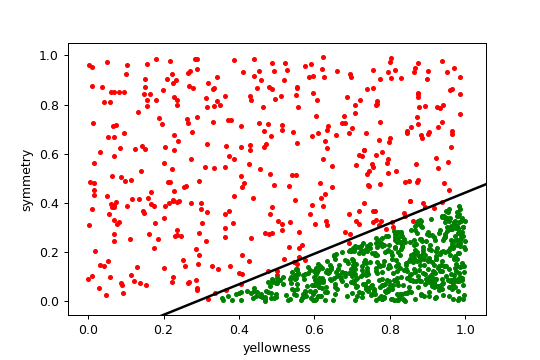

In [13]:
%matplotlib nbagg

np.random.seed(1)
fig = plt.figure()
plt.scatter(data[apples][:, 0], data[apples][:, 1], color = "red", marker=".", label="Apples")
plt.scatter(data[pears][:, 0], data[pears][:, 1], color = "green", marker=".", label="Pears")
plt.xlabel("yellowness")
plt.ylabel("symmetry")
line, = plt.plot([], [], color="black", linewidth=2)  # создаём линию, которая будет показывать границу разделения

from matplotlib.animation import FuncAnimation

perceptron_for_weights_line = create_perceptron(2)  # создаём перцептрон нужной размерности со случайными весами

from functools import partial
weights_ani = partial(
    step_by_step_weights, p=perceptron_for_weights_line, input_matrix=data[:, :-1], y=data[:, -1][:,np.newaxis]
)  # про partial почитайте на https://docs.python.org/3/library/functools.html#functools.partial

ani = FuncAnimation(fig, func=plot_line, frames=weights_ani, blit=False, interval=10, repeat=True)
# если Jupyter не показывает вам анимацию - раскомментируйте строчку ниже и посмотрите видео
# ani.save("perceptron_seeking_for_solution.mp4", fps=15)
plt.show()

## Не забудьте остановить генерацию новых картинок, прежде чем идти дальше (кнопка "выключить" в правом верхнем углу графика)

Воспользуемся несколькими примерами, чтобы проиллюстрировать философию обучения перцептрона, которая не всегда интуитивна.

Во-первых, количество неправильно классифицированных примеров не всегда уменьшается. То есть в процессе обучения у перцептрона могут случаться "взлёты и падения".

In [14]:
def step_by_step_errors(p, input_matrix, y, max_steps=1e6):
    """
    обучает перцептрон последовательно на каждой строчке входных данных, 
    на каждом шаге обучения запоминает количество неправильно классифицированных примеров
    и возвращает список из этих количеств
    """
    def count_errors():
        return np.abs(p.vectorized_forward_pass(input_matrix).astype(np.int) - y).sum()
    errors_list = [count_errors()]
    i = 0
    errors = 1
    while errors and i < max_steps:
        i += 1
        errors = 0
        for example, answer in zip(input_matrix, y):
            example = example.reshape((example.size, 1))
            
            error = p.train_on_single_example(example, answer)
            errors += error
            errors_list.append(count_errors())
    return errors_list

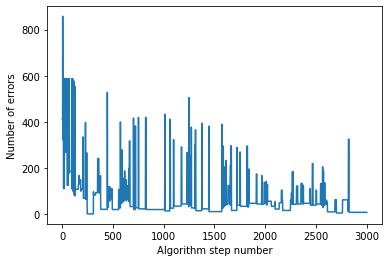

In [15]:
%matplotlib inline
perceptron_for_misclassification = create_perceptron(2)
errors_list = step_by_step_errors(perceptron_for_misclassification, input_matrix=data[:, :-1], y=data[:, -1][:,np.newaxis])
plt.plot(errors_list);
plt.ylabel("Number of errors")
plt.xlabel("Algorithm step number");

Такой страшный график - следствие нашей философии. Ведь философия обучения перцептрона в том, что лучше будут становиться веса, а не ответы.

"А как именно веса становятся лучше?" - вот вопрос, который теперь волновал каждого из нас. Мы решили посмотреть, как перцептрон научился тому, чему он научился. Возьмём тот вектор весов, к которым перцептрон сошёлся, и посмотрим, как изменяется расстояние до него, пока перцептрон учится.

In [16]:
def get_vector(p):
    """возвращает вектор из всех весов перцептрона, включая смещение"""
    v = np.array(list(p.w.ravel()) + [p.b])
    return v

In [17]:
def step_by_step_distances(p, ideal, input_matrix, y, max_steps=1e6):
    """обучает перцептрон p и записывает каждое изменение расстояния от текущих весов до ideal"""
    distances = [norm(get_vector(p) - ideal)]
    i = 0
    errors = 1
    while errors and i < max_steps:
        i += 1
        errors = 0
        for example, answer in zip(input_matrix, y):
            example = example.reshape((example.size, 1))
            
            error = p.train_on_single_example(example, answer)
            errors += error
            if error:
                distances.append(norm(get_vector(p) - ideal))
    return distances

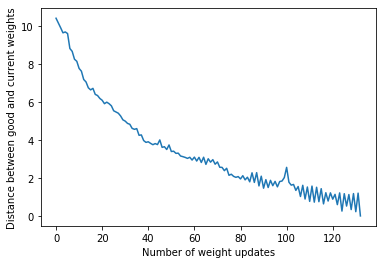

In [18]:
%matplotlib inline

np.random.seed(42)
init_weights = np.random.random_sample(3)
w, b = init_weights[:-1].reshape((2, 1)), init_weights[-1]
ideal_p = Perceptron(w.copy(), b.copy())
ideal_p.train_until_convergence(data[:, :-1], data[:, -1][:,np.newaxis])
ideal_weights = get_vector(ideal_p)

new_p = Perceptron(w.copy(), b.copy())
distances = step_by_step_distances(new_p, ideal_weights, data[:, :-1], data[:, -1][:,np.newaxis])

plt.xlabel("Number of weight updates")
plt.ylabel("Distance between good and current weights")
plt.plot(distances);

Как и можно было догадаться ещё по тому, как вела себя прямая на нашей анимированной картинке, вектор весов постепенно приближается к множеству хороших весов, хотя тоже "не всё гладко". Постарайтесь понять, почему, вспомнив доказательство сходимости перцептрона и понятие "векторов весов, хороших "с запасом"".

# Градиентный спуск

Покончив с перцептроном, предлагаем посмотреть, как в подобной ситуации себя проявит логистический нейрон, основанный на градиентном спуске.
Вдруг когда-нибудь попадётся какое-то "необычное" яблоко или груша. Тогда данные могут перестать быть линейно разделимыми, и он рискует зависнуть, обучая несходящийся перцептрон. 

Конечно, можно поставить ограничение на число шагов алгоритма... Но если вспомнить, как выглядит график количества ошибок, сразу станет понятно, что мы рискуем получить очень плохой классификатор, если оборвём процесс обучения раньше, чем нужно.

Посмотрим на его заготовку,заполнив не достающие элементы.

In [9]:
## Определим разные полезные функции

def sigmoid(x):
    """сигмоидальная функция, работает и с числами, и с векторами (поэлементно)"""
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    """производная сигмоидальной функции, работает и с числами, и с векторами (поэлементно)"""
    return sigmoid(x) * (1 - sigmoid(x))

Класс Neuron нас немного напугал... Такая махина. Он только кажется большим. На самом деле можно было всё это написать в три-четыре строчки, но вот понять их - это было бы сложнее. 

Неоптимальность реализации, обусловлена тем, что "на таком удобнее учиться".

In [10]:
class Neuron:
    
    def __init__(self, weights, activation_function=sigmoid, activation_function_derivative=sigmoid_prime):
        """
        weights - вертикальный вектор весов нейрона формы (m, 1), weights[0][0] - смещение
        activation_function - активационная функция нейрона, сигмоидальная функция по умолчанию
        activation_function_derivative - производная активационной функции нейрона
        """
        
        assert weights.shape[1] == 1, "Incorrect weight shape"
        
        self.w = weights
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
        
    def forward_pass(self, single_input):
        """
        активационная функция логистического нейрона
        single_input - вектор входов формы (m, 1), 
        первый элемент вектора single_input - единица (если вы хотите учитывать смещение)
        """
        
        result = 0
        for i in range(self.w.size):
            result += float(self.w[i] * single_input[i])
        return self.activation_function(result)
    
    def summatory(self, input_matrix):
        """
        Вычисляет результат сумматорной функции для каждого примера из input_matrix. 
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных.
        Возвращает вектор значений сумматорной функции размера (n, 1).
        """
        
        # your code goes here
        return input_matrix.dot(self.w) #np.dot(input_matrix, self.w)
    
    def activation(self, summatory_activation):
        """
        Вычисляет для каждого примера результат активационной функции,
        получив на вход вектор значений сумматорной функций
        summatory_activation - вектор размера (n, 1), 
        где summatory_activation[i] - значение суммматорной функции для i-го примера.
        Возвращает вектор размера (n, 1), содержащий в i-й строке 
        значение активационной функции для i-го примера.
        """
        
        # your code goes here
        return self.activation_function(summatory_activation)#1/(1+np.exp(-summatory_activation))

    def vectorized_forward_pass(self, input_matrix):
        """
        Векторизованная активационная функция логистического нейрона.
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных.
        Возвращает вертикальный вектор размера (n, 1) с выходными активациями нейрона
        (элементы вектора - float)
        """
        return self.activation(self.summatory(input_matrix))
        
    def SGD(self, X, y, batch_size, learning_rate=0.1, eps=1e-6, max_steps=200):
        """
        Внешний цикл алгоритма градиентного спуска.
        X - матрица входных активаций (n, m)
        y - вектор правильных ответов (n, 1)
        
        learning_rate - константа скорости обучения
        batch_size - размер батча, на основании которого 
        рассчитывается градиент и совершается один шаг алгоритма
        
        eps - критерий остановки номер один: если разница между значением целевой функции 
        до и после обновления весов меньше eps - алгоритм останавливается. 
        Вторым вариантом была бы проверка размера градиента, а не изменение функции,
        что будет работать лучше - неочевидно. В заданиях используйте первый подход.
        
        max_steps - критерий остановки номер два: если количество обновлений весов 
        достигло max_steps, то алгоритм останавливается
        
        Метод возвращает 1, если отработал первый критерий остановки (спуск сошёлся) 
        и 0, если второй (спуск не достиг минимума за отведённое время).
        """
        
        # your code goes here
        #ind_list=np.arrange[0:X.shape[0]]
        #X_stack_y=np.hstack((X, y)) # Для отбора примеров сразу с ответом для обучения
        i=0
        while i < max_steps:
            ind_list=np.random.choice(X.shape[0], batch_size, replace=False)#получили рандомные данные из всех
            '''
            X_stack_y2=X_stack_y[ind_list] #берем данные/батч по индексам ранд.генерация # ind = [1,5,3]->X[ind] 
            X_shuffled=np.array(X_stack_y2[:,0:-1])#кладем в икс все строки, без последнего столбца
            y_shuffled=np.reshape(np.array(X_stack_y2[:,-1]), (batch_size,1))#все строки последнего столбца, корректируем форму 
            '''
            X_shuffled=X[ind_list]
            y_shuffled=y[ind_list]
            if self.update_mini_batch(X=X_shuffled, y=y_shuffled, learning_rate=learning_rate, eps=eps) == 1:
                return 1
            else:
                i+=1
        return 0
    
    def update_mini_batch(self, X, y, learning_rate, eps):
        """
        X - матрица размера (batch_size, m)
        y - вектор правильных ответов размера (batch_size, 1)
        learning_rate - константа скорости обучения
        eps - критерий остановки номер один: если разница между значением целевой функции 
        до и после обновления весов меньше eps - алгоритм останавливается. 
        
        Рассчитывает градиент (не забывайте использовать подготовленные заранее внешние функции) 
        и обновляет веса нейрона. Если ошибка изменилась меньше, чем на eps - возвращаем 1, 
        иначе возвращаем 0.
        """
        
        # your code goes here
        nabla_j = compute_grad_analytically(self, X, y)#Вычисляем Ggrad целевой функции;
        delta_w = learning_rate * nabla_j
        J_old = J_quadratic(self, X, y)  
        self.w -= delta_w                              #Вычисляем new W_i  
        J_new = J_quadratic(self, X, y)                #Вычисляем update значение целевой функции with new W_i;
        if J_old - J_new < eps:
            return 1
        else:
            return 0

'''
temp_w1 = vectorized_forward_pass(self, X)
for_grad1 = J_quadratic(neuron=self, X, y)#Вычисляем значение целевой функции;
temp_w2=temp_w1 - learning_rate*J_quadratic_derivative(y, y_hat=temp_w1) 
self.w=temp_w2
for_grad2 = J_quadratic(neuron=self, X, y)#Вычисляем новое значение целевой функции;
if for_grad1 - for_grad2 < eps:
    return 1
else:
    return 0
'''

'\ntemp_w1 = vectorized_forward_pass(self, X)\nfor_grad1 = J_quadratic(neuron=self, X, y)#Вычисляем значение целевой функции;\ntemp_w2=temp_w1 - learning_rate*J_quadratic_derivative(y, y_hat=temp_w1) \nself.w=temp_w2\nfor_grad2 = J_quadratic(neuron=self, X, y)#Вычисляем новое значение целевой функции;\nif for_grad1 - for_grad2 < eps:\n    return 1\nelse:\n    return 0\n'

 $${\Delta w} = {-\alpha}*{\nabla J(w_{j})}$$
 $$ w_{j+1} = w_{j} + {\Delta w_{j}} $$
 
 - Расстояние между $w_{j}$ и $w_{j+1}$ разное для разных j
 - Разница между $J(w_{j})$ и $J(w_{j+1})$ разная для разных j
 - Для всех j: $J(w_{j})>J(w_{j+1})$ при достаточно малом ${\alpha}$


На практике стохастический градиентный спуск обычно ограничивается не по количеству шагов алгоритма, а по количеству эпох обучения. 

Эпохой обучения называют предъявление всех примеров по одному разу. Обычно батчи формируют так: входные данные перемешиваются, после этого разбиваются на кусочки по batch_size штук в каждом. После того как все примеры хотя бы раз побывали в батче, данные перемешиваются снова.

Сейчас нам интересно понаблюдать за отдельными изменениями весов, поэтому мы ограничиваем алгоритм не эпохами, а количеством обновлений весов.

Код для расчета целевой функции и её градиента. Приятно было осознавать, что целевую функцию можно будет очень легко заменить, если нам захочется.

In [11]:
def J_quadratic(neuron, X, y):
    """
    Оценивает значение квадратичной целевой функции.
    Всё как в лекции, никаких хитростей.

    neuron - нейрон, у которого есть метод vectorized_forward_pass, предсказывающий значения на выборке X
    X - матрица входных активаций (n, m)
    y - вектор правильных ответов (n, 1)
        
    Возвращает значение J (число)
    """
    
    assert y.shape[1] == 1, 'Incorrect y shape'
    
    return 0.5 * np.mean((neuron.vectorized_forward_pass(X) - y) ** 2)

def J_quadratic_derivative(y, y_hat):
    """
    Вычисляет вектор частных производных целевой функции по каждому из предсказаний.
    y_hat - вертикальный вектор предсказаний,
    y - вертикальный вектор правильных ответов,
    
    В данном случае функция смехотворно простая, но если мы захотим поэкспериментировать 
    с целевыми функциями - полезно вынести эти вычисления в отдельный этап.
    
    Возвращает вектор значений производной целевой функции для каждого примера отдельно.
    """
    
    assert y_hat.shape == y.shape and y_hat.shape[1] == 1, 'Incorrect shapes'
    
    return (y_hat - y) / len(y)
    
def compute_grad_analytically(neuron, X, y, J_prime=J_quadratic_derivative):
    """
    Аналитическая производная целевой функции
    neuron - объект класса Neuron
    X - вертикальная матрица входов формы (n, m), на которой считается сумма квадратов отклонений
    y - правильные ответы для примеров из матрицы X
    J_prime - функция, считающая производные целевой функции по ответам
    
    Возвращает вектор размера (m, 1)
    """
    
    # Вычисляем активации
    # z - вектор результатов сумматорной функции нейрона на разных примерах
    z = neuron.summatory(X)
    y_hat = neuron.activation(z)

    # Вычисляем нужные нам частные производные
    dy_dyhat = J_prime(y, y_hat)
    dyhat_dz = neuron.activation_function_derivative(z)
    
    # осознайте эту строчку:
    dz_dw = X

    # а главное, эту:
    grad = ((dy_dyhat * dyhat_dz).T).dot(dz_dw)
    
    # можно было написать в два этапа. Осознайте, почему получается одно и то же
    # grad_matrix = dy_dyhat * dyhat_dz * dz_dw
    # grad = np.sum(, axis=0)
    
    # Сделаем из горизонтального вектора вертикальный
    grad = grad.T
    
    return grad

$$ \hat{y}({x^{i}}) = y^{predict}({x^{i}}) = \sigma({w^{T}*x^{i}}) $$

$$\frac{\partial J}{\partial w_i} =\frac{1}{n} * \sum{[\hat{y}({x^{i}}) - y_{i}]*\hat{y}({x^{i}})*[1-\hat{y}({x^{i}})]*x^{i}_{k} }$$

$$\frac{\partial J}{\partial w_i} =\frac{1}{n} * [\hat{y}({x^{i}}) - y_{i}]*\hat{y}({x^{i}})*[1-\hat{y}({x^{i}})]*x^{i}_{k} $$

А вдруг при расчёте градиента допущена ошибка?  

Как мы говорили в лекциях, неплохо бы проверить, правильно ли мы считаем градиенты, до того, как куда-то по этим градиентам спускаться.

Сейчас мы проверим, правильно ли считаются производные целевой функции: мы реализуем подсчёт частных производных по определению, как $$\frac{\partial f}{\partial x_i} = \frac{f\left(x_1,\ldots,x_{i-1}, x_i + \Delta x, x_{i+1}, \ldots, x_d\right) - f\left(x_1,\ldots, x_d\right)}{\Delta x}.$$ Это не определение, в определении был бы $\lim _{\Delta x\to 0}$! Но если мы возьмём достаточно малое $\Delta x$, то приближение будет неплохим.

Иными словами, мы посчитаем целевую функцию, чуть-чуть поменяем какой-нибудь вес, после этого посчитаем целевую функцию еще раз, дальше применяем определение, то есть разделим разницу в целевой функции на изменение веса.

После этого можно будет сравнить результаты, полученные с помощью аналитического и численного метода: они не должны сильно отличаться.

Мы не можем всегда обходиться только лишь численным нахождением производной, но пример, непосредственно это иллюстрирующий, появится на следующей неделе.

In [12]:
def compute_grad_numerically(neuron, X, y, J=J_quadratic, eps=10e-2):
    """
    Численная производная целевой функции
    neuron - объект класса Neuron
    X - вертикальная матрица входов формы (n, m), на которой считается сумма квадратов отклонений
    y - правильные ответы для тестовой выборки X
    J - целевая функция, градиент которой мы хотим получить
    eps - размер $\delta w$ (малого изменения весов)
    """

    initial_cost = J(neuron, X, y)
    w_0 = neuron.w
    num_grad = np.zeros(w_0.shape)
    
    for i in range(len(w_0)):
        
        old_wi = neuron.w[i].copy()
        # Меняем вес
        neuron.w[i] += eps
        
        # Считаем новое значение целевой функции и вычисляем приближенное значение градиента
        num_grad[i] = (J(neuron, X, y) - initial_cost)/eps
        
        # Возвращаем вес обратно. Лучше так, чем -= eps, чтобы не накапливать ошибки округления
        neuron.w[i] = old_wi
            
    # проверим, что не испортили нейрону веса своими манипуляциями
    assert np.allclose(neuron.w, w_0), "МЫ ИСПОРТИЛИ НЕЙРОНУ ВЕСА"
    return num_grad

Посмотрим, что у нас получилось:

In [13]:
# Подготовим данные

X = data[:, :-1]
y = data[:, -1]

X = np.hstack((np.ones((len(y), 1)), X))
y = y.reshape((len(y), 1)) # Обратите внимание на эту очень противную и важную строчку


# Создадим нейрон

w = np.random.random((X.shape[1], 1))
neuron = Neuron(w, activation_function=sigmoid, activation_function_derivative=sigmoid_prime)

# Посчитаем пример
num_grad = compute_grad_numerically(neuron, X, y, J=J_quadratic)
an_grad = compute_grad_analytically(neuron, X, y, J_prime=J_quadratic_derivative)

print("Численный градиент: \n", num_grad)
print("Аналитический градиент: \n", an_grad)

Численный градиент: 
 [[ 0.01023245]
 [-0.0109698 ]
 [ 0.02702695]]
Аналитический градиент: 
 [[ 0.00763181]
 [-0.01241033]
 [ 0.02688906]]


"Вроде бы похоже", но это не очень удовлетворительный ответ. Давайте посмотрим, как меняется наше приближение в зависимости от $\varepsilon$. Посчитаем для разных $\varepsilon$ модуль разности этих двух градиентов.

In [14]:
def print_grad_diff(eps):
    num_grad = compute_grad_numerically(neuron, X, y, J=J_quadratic, eps=float(eps))
    an_grad = compute_grad_analytically(neuron, X, y, J_prime=J_quadratic_derivative)
    print(np.linalg.norm(num_grad-an_grad))
    
interact(print_grad_diff, 
            eps=RadioButtons(options=["3", "1", "0.1", "0.001", "0.0001"]), separator=" ");

interactive(children=(RadioButtons(description='eps', options=('3', '1', '0.1', '0.001', '0.0001'), value='3')…

Неплохо, но можно лучше, причем с минимумом усилий.
Давайте вместо того, чтобы считать $\frac{f(x) - f(x + \Delta x)}{\Delta x}$, посмотрим на $\frac{f(x  + \Delta x) - f(x - \Delta x)}{2 \Delta x}$, то есть шагнём в обе стороны. Говорят, что на практике этот метод работает лучше.

Реализуйте функцию compute_grad_numerically_2, чтобы проверить, слухи это или нет.

$$\frac{J( ...+ w_i + \Delta w + ...) - J( ...+ w_i - \Delta w + ...)}{2 * \Delta w}$$

In [15]:
def compute_grad_numerically_2(neuron, X, y, J=J_quadratic, eps=10e-2):
    """
    Численная производная целевой функции.
    neuron - объект класса Neuron с вертикальным вектором весов w,
    X - вертикальная матрица входов формы (n, m), на которой считается сумма квадратов отклонений,
    y - правильные ответы для тестовой выборки X,
    J - целевая функция, градиент которой мы хотим получить,
    eps - размер $\delta w$ (малого изменения весов).
    """
    # эту функцию необходимо реализовать #pass
    # here goes your code
    
    initial_cost = J(neuron, X, y)
    w_0 = neuron.w
    num_grad = np.zeros(w_0.shape)
    
    for i in range(len(w_0)):
        
        old_wi = neuron.w[i].copy()
        # Меняем вес
        neuron.w[i] += eps 
        J_delta_plus=J(neuron, X, y)
        neuron.w[i] = old_wi
        neuron.w[i] -= eps
        J_delta_minus=J(neuron, X, y)
        
        # Считаем новое значение целевой функции и вычисляем приближенное значение градиента
        num_grad[i] = (J_delta_plus - J_delta_minus)/(2*eps)
        
        # Возвращаем вес обратно. Лучше так, чем -= eps, чтобы не накапливать ошибки округления
        neuron.w[i] = old_wi
            
    # проверим, что не испортили нейрону веса своими манипуляциями
    assert np.allclose(neuron.w, w_0), "МЫ ИСПОРТИЛИ НЕЙРОНУ ВЕСА"
    return num_grad

Посмотрим, к какому результату привели ваши эксперименты:

In [16]:
def print_grad_diff_2(eps):
    num_grad = compute_grad_numerically_2(neuron, X, y, J=J_quadratic, eps=float(eps))
    an_grad = compute_grad_analytically(neuron, X, y, J_prime=J_quadratic_derivative)
    print(np.linalg.norm(num_grad-an_grad))
    
interact(print_grad_diff_2, 
            eps=RadioButtons(options=["3", "1", "0.1", "0.001", "0.0001"]), separator=" ");

interactive(children=(RadioButtons(description='eps', options=('3', '1', '0.1', '0.001', '0.0001'), value='3')…

Перед нами тот редкий случай, когда фраза **"на порядок лучше"** - очевидное преуменьшение!

## Визуализация

У нас ведь всего два входа! 

Если мы зафиксируем значение смещения, то можем полноценно визуализировать целевую функцию. 
А еще давайте добавим возможность перемешивать и сдвигать данные! 

In [17]:
def J_by_weights(weights, X, y, bias):
    """
    Посчитать значение целевой функции для нейрона с заданными весами.
    Только для визуализации
    """
    new_w = np.hstack((bias, weights)).reshape((3,1))
    return J_quadratic(Neuron(new_w), X, y)

In [19]:
%matplotlib inline

max_b = 40
min_b = -40
max_w1 = 40
min_w1 = -40
max_w2 = 40
min_w2 = -40

g_bias = 0 # график номер 2 будет при первой генерации по умолчанию иметь то значение b, которое выставлено в первом
X_corrupted = X.copy()
y_corrupted = y.copy()

@interact(fixed_bias=FloatSlider(min=min_b, max=max_b, continuous_update=False), 
          mixing=FloatSlider(min=0, max=1, continuous_update=False, value=0),
          shifting=FloatSlider(min=0, max=1, continuous_update=False, value=0)
            )
def visualize_cost_function(fixed_bias, mixing, shifting):
    """
    Визуализируем поверхность целевой функции на (опционально) подпорченных данных и сами данные.
    Портим данные мы следующим образом: сдвигаем категории навстречу друг другу, на величину, равную shifting 
    Кроме того, меняем классы некоторых случайно выбранных примеров на противоположнее.
    Доля таких примеров задаётся переменной mixing
    
    Нам нужно зафиксировать bias на определённом значении, чтобы мы могли что-нибудь визуализировать.
    Можно посмотреть, как bias влияет на форму целевой функции
    """
    xlim = (min_w1, max_w1)
    ylim = (min_w2, max_w2)
    xx = np.linspace(*xlim, num=101)
    yy = np.linspace(*ylim, num=101)
    xx, yy = np.meshgrid(xx, yy)
    points = np.stack([xx, yy], axis=2)
    
    # не будем портить исходные данные, будем портить их копию
    corrupted = data.copy()
    
    # инвертируем ответы для случайно выбранного поднабора данных
    mixed_subset = np.random.choice(range(len(corrupted)), int(mixing * len(corrupted)), replace=False)
    corrupted[mixed_subset, -1] = np.logical_not(corrupted[mixed_subset, -1])
    
    # сдвинем все груши (внизу справа) на shifting наверх и влево
    pears = corrupted[:, 2] == 1
    apples = np.logical_not(pears)
    corrupted[pears, 0] -= shifting
    corrupted[pears, 1] += shifting
    
    # вытащим наружу испорченные данные
    global X_corrupted, y_corrupted
    X_corrupted = np.hstack((np.ones((len(corrupted),1)), corrupted[:, :-1]))
    y_corrupted = corrupted[:, -1].reshape((len(corrupted), 1))
    
    # посчитаем значения целевой функции на наших новых данных
    calculate_weights = partial(J_by_weights, X=X_corrupted, y=y_corrupted, bias=fixed_bias)
    J_values = np.apply_along_axis(calculate_weights, -1, points)
    
    fig = plt.figure(figsize=(16,5))
    # сначала 3D-график целевой функции
    ax_1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax_1.plot_surface(xx, yy, J_values, alpha=0.3)
    ax_1.set_xlabel("$w_1$")
    ax_1.set_ylabel("$w_2$")
    ax_1.set_zlabel("$J(w_1, w_2)$")
    ax_1.set_title("$J(w_1, w_2)$ for fixed bias = ${}$".format(fixed_bias))
    # потом плоский поточечный график повреждённых данных
    ax_2 = fig.add_subplot(1, 2, 2)
    plt.scatter(corrupted[apples][:, 0], corrupted[apples][:, 1], color = "red", alpha=0.7)
    plt.scatter(corrupted[pears][:, 0], corrupted[pears][:, 1], color = "green", alpha=0.7)
    ax_2.set_xlabel("yellowness")
    ax_2.set_ylabel("symmetry")

    plt.show()
    plt.save()

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='fixed_bias', max=40.0, min=…

По форме функции становилось понятно, что градиентный спуск будет обычно попадать в ловушку. На графике видна огромная яма, прижимающаяся своим дном к нулю. 

Это происходит от того, что данные линейно разделимы, и мы всегда можем увеличить хорошие веса, получив еще более хорошие (подумайте, почему это так).

Еще страшнее выглядят плоские участки.

Следующий график особенно нас порадовал. Можно было выбрать точку и bias, откуда мы хотим начать градиентный спуск, после чего его программа генерировала "историю обучения" (learning curve) - график значений целевой функции после очередного обновления весов. 

Смотря на поверхность целевой функции мы старались предсказать, к каким весам мы придём, если начнём спуск с той или иной точки. Оказалось что всё не так очевидно, как мы думали.

На графике ниже видно, что при "хорошем" раскладе (мы попали в большую яму) значение целевой функции всё время уменьшалось (хоть и по чуть-чуть), пока мы не достигали порога по количеству итераций. При плохом мы могли просто застрять в локальном минимуме или выйти на плато. 


***Если в предыдущем задании вы "подпортили" данные - график будет строиться именно для подпорченных =)***

In [29]:
@interact(b=BoundedFloatText(value=str(g_bias), min=min_b, max=max_b, description="Enter $b$:"),
          w1=BoundedFloatText(value="0", min=min_w1, max=max_w1, description="Enter $w_1$:"),
          w2=BoundedFloatText(value="0", min=min_w2, max=max_w2, description="Enter $w_2$:"),
          learning_rate=Dropdown(options=["0.01", "0.05", "0.1", "0.5", "1", "5", "10"], 
                                value="0.01", description="Learning rate: ")
         )
def learning_curve_for_starting_point(b, w1, w2, learning_rate=0.1):
    w = np.array([b, w1, w2]).reshape(X_corrupted.shape[1], 1)
    learning_rate=float(learning_rate)
    neuron = Neuron(w, activation_function=sigmoid, activation_function_derivative=sigmoid_prime)

    story = [J_quadratic(neuron, X_corrupted, y_corrupted)]
    for _ in range(2000):
        neuron.SGD(X_corrupted, y_corrupted, 2, learning_rate=learning_rate, max_steps=2)
        story.append(J_quadratic(neuron, X_corrupted, y_corrupted))
    plt.plot(story)
    
    plt.title("Learning curve.\n Final $b={0:.3f}$, $w_1={1:.3f}, w_2={2:.3f}$".format(*neuron.w.ravel()))
    plt.ylabel("$J(w_1, w_2)$")
    plt.xlabel("Weight and bias update number")
    plt.show()

interactive(children=(BoundedFloatText(value=0.0, description='Enter $b$:', max=40.0, min=-40.0), BoundedFloat…

В следующий раз мы сможем сделать настоящую нейросеть.

Однако, не все. Кто-то из наших так увлёкся, что уже сейчас, не дожидаясь следующей встречи, отправился заменять целевые и активационные функции нейронов, наблюдая, как это отразится на результатах.